## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from matplotlib import ticker
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

In [2]:
df = pd.read_csv("ABBV-AbbVie.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,79.769997,80.849998,79.279999,80.099998,62.999912,8567900
1,2019-03-04,80.400002,80.730003,79.110001,79.459999,62.496529,5872500
2,2019-03-05,79.379997,79.900002,78.720001,78.910004,62.063969,5933100
3,2019-03-06,79.129997,79.129997,77.559998,78.089996,61.419025,5293200
4,2019-03-07,77.769997,79.120003,77.440002,78.239998,61.537003,6642500
...,...,...,...,...,...,...,...
1254,2024-02-23,177.259995,178.910004,177.009995,178.089996,176.442200,3941800
1255,2024-02-26,178.839996,179.789993,178.000000,178.809998,177.155533,4327400
1256,2024-02-27,178.770004,179.529999,176.979996,178.990005,177.333878,3888500
1257,2024-02-28,179.850006,179.889999,176.889999,178.000000,176.353043,4331300


## Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

## Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

## Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:4
train_size = int(0.6 * len(data_scaled))
test_size = len(data_scaled) - train_size

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Model training and testing

## Training process

In [7]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [8]:
# Find the best ARIMA model using auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4358.360, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4360.717, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4361.498, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4361.192, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4360.071, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4361.581, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4360.219, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4360.178, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4360.291, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4358.230, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4360.919, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.720 seconds


In [9]:
# Fit the model
model.fit(y_train)

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True)

## Validate Processing

## Testing Processing

In [10]:
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

## Evaluate Model

In [11]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.1558184213933927
RMSE on Test dataset:  26.807256506844283
MSLE on Test dataset:  0.026882138940434445


# Predicting the next 60 days

## Preparing the prediction data

In [12]:
# The process of creating index predict next 60 days
last_index = df_Close.index[-1]

# Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)

## Prediction process

In [13]:
# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days))
y_next_60_days = scaler.inverse_transform(np.array([y_next_60_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days.flatten())

Predicted closing prices for the next 60 days:
[149.3043412  149.63563125 149.69570727 149.80155215 149.89039335
 149.98264455 150.07379822 150.16519609 150.25652171 150.34786446
 150.43920238 150.53054149 150.62188028 150.71321915 150.804558
 150.89589685 150.9872357  151.07857455 151.1699134  151.26125226
 151.35259111 151.44392996 151.53526881 151.62660766 151.71794651
 151.80928537 151.90062422 151.99196307 152.08330192 152.17464077
 152.26597963 152.35731848 152.44865733 152.53999618 152.63133503
 152.72267388 152.81401274 152.90535159 152.99669044 153.08802929
 153.17936814 153.27070699 153.36204585 153.4533847  153.54472355
 153.6360624  153.72740125 153.8187401  153.91007896 154.00141781
 154.09275666 154.18409551 154.27543436 154.36677322 154.45811207
 154.54945092 154.64078977 154.73212862 154.82346747 154.91480633]


## Preparing the forecast date index

In [14]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

## Visualization

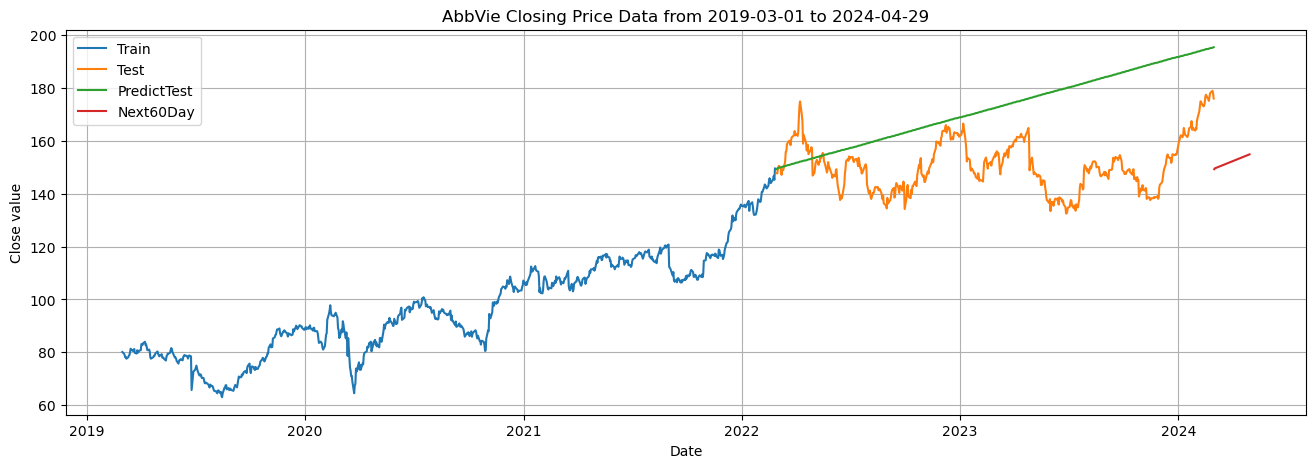

In [15]:
# Drawing
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_60_days, y_next_60_days)

plt.legend(['Train', 'Test', 'PredictTest', 'Next60Day'])
plt.grid()
plt.title(f"AbbVie Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('image/ARIMA_64_60day_ABBV.png')
plt.show()